In [1]:
%pylab inline

import keras
from vis.utils import utils

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Filter Visualization

Before we design networks with the explicit goal of generating images, we start with an early appraoch that led to image generation. CNNs have been at the forefront of image recognition for years [TODO: cite] but one common complain is that these models are not very interpretable. A lot of work has been done to provide some level of interpretation. One promising route is to visualize the inputs which activate certain convolutional filters. 


Resources:
- Distil's great overview of filter visualization [here](https://distill.pub/2017/feature-visualization/)
- Kears visualization libaray [here](https://raghakot.github.io/keras-vis/)
- Jacob Gil, Visualizing CNN filters with keras. Blog post with code [here](https://jacobgil.github.io/deeplearning/filter-visualizations)

# Let's start with a standard CNN for MNIST

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_max = x_train.max()

x_train = x_train[...,None]/train_max # add axis and divide by max to scale [0,1]
x_test = x_test[...,None]/train_max

N_CAT = y_train.max() +1

In [9]:
DROPOUT = 0.05

model_layers = [
    keras.layers.InputLayer(input_shape=x_train.shape[1:]),
    
    keras.layers.Conv2D(15, 3, activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(DROPOUT),
    
    keras.layers.Conv2D(15, 3, activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(DROPOUT),
    
    keras.layers.Conv2D(15, 3, activation="relu"),
        
    keras.layers.Flatten(),
    keras.layers.Dropout(DROPOUT),
    
    keras.layers.Dense(N_CAT, activation="softmax", name="predictions" )
]
model = keras.Sequential(model_layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 15)        150       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 15)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 15)        2040      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 5, 15)          0         
__________

In [10]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=1, cooldown=1, verbose=1),
    keras.callbacks.EarlyStopping(patience=5, verbose=1)
]
model.compile("nadam", "sparse_categorical_crossentropy", metrics=["acc"])

model.fit(
    x_train,
    y_train,
    batch_size=32,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 232us/step - loss: 0.2314 - acc: 0.9273 - val_loss: 0.0752 - val_acc: 0.9760
Epoch 2/100
60000/60000 [==============================] - 13s 216us/step - loss: 0.0830 - acc: 0.9742 - val_loss: 0.0449 - val_acc: 0.9855
Epoch 3/100
60000/60000 [==============================] - 13s 216us/step - loss: 0.0662 - acc: 0.9796 - val_loss: 0.0467 - val_acc: 0.9849

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 4/100
60000/60000 [==============================] - 13s 219us/step - loss: 0.0489 - acc: 0.9843 - val_loss: 0.0344 - val_acc: 0.9888
Epoch 5/100
60000/60000 [==============================] - 13s 221us/step - loss: 0.0455 - acc: 0.9859 - val_loss: 0.0347 - val_acc: 0.9884

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
60000/60000 [==============================] - 13s 218us/step - loss: 0.0398

In [11]:
from vis.visualization import visualize_activation
from vis.utils import utils
from vis.input_modifiers import Jitter
input_modifiers=[Jitter()]

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

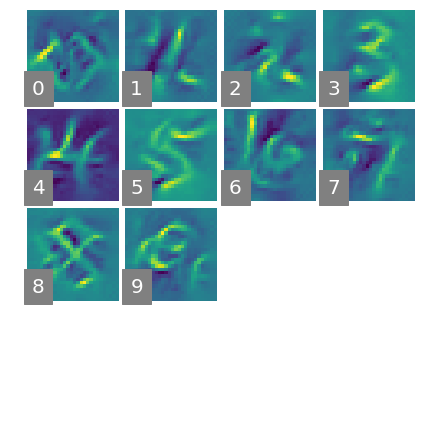

In [24]:
fig, axes = subplots(
    nrows=4, ncols=4, figsize=(6, 6), sharex=True, sharey=True, frameon=False)

fontdict = {
    "backgroundcolor": "gray",
    "color": "white",
    "size": 20,
}

for i in range(10):
    ax = axes.flat[i]

    filter_idx = i
    img = visualize_activation(
        model,
        layer_idx,
        filter_indices=filter_idx,
        input_range=(0., 1.),
        max_iter=400,
        act_max_weight=3,
        lp_norm_weight=10,
        tv_weight=10,
        input_modifiers=[Jitter()]
    )

    ax.imshow(img[..., 0], aspect="auto")

    ax.text(1, 25, filter_idx, fontdict=fontdict)
    ax.axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout(h_pad=0, w_pad=0)

# This is the output node we want to maximize.

# Now with VGG

In [25]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(vgg, 'predictions')

# Swap softmax with linear
vgg.layers[layer_idx].activation = keras.activations.linear
vgg = utils.apply_modifications(vgg)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [27]:
import numpy as np

finding act_max_weight=10**-0.5
finding act_max_weight=10**-0.12499999999999996
finding act_max_weight=10**0.24999999999999997
finding act_max_weight=10**0.625
finding act_max_weight=10**1.0


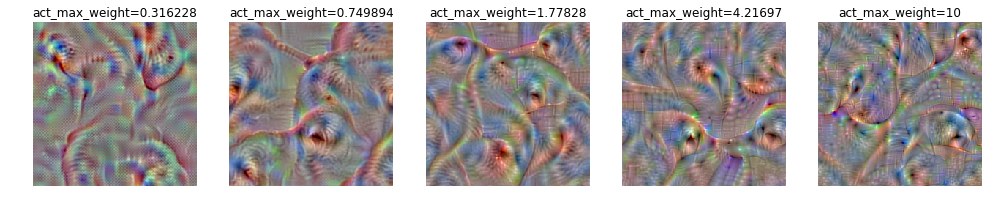

In [28]:
figsize(17,5)

fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True)

for i, act_val in enumerate(np.logspace(-.5,1,5)):
    print(f"finding act_max_weight=10**{np.log10(act_val)}")

    img = visualize_activation(
        vgg, 
        layer_idx, 
        filter_indices=208,
        act_max_weight=act_val, 
        lp_norm_weight=10, 
        tv_weight=10,
        input_modifiers=[Jitter()]
    )
    
    axes[i].imshow(img)
    axes[i].set_title(f"act_max_weight={act_val:g}")
    axes[i].axis("off")

finding lp_norm_weight=10**0.0
finding lp_norm_weight=10**0.5
finding lp_norm_weight=10**1.0
finding lp_norm_weight=10**1.5
finding lp_norm_weight=10**2.0


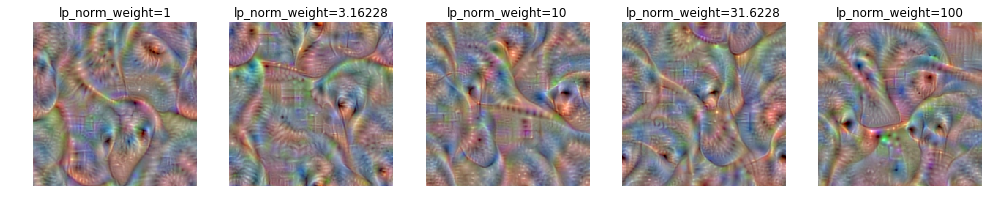

In [29]:
figsize(17,5)

fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True)

for i, lp_val in enumerate(np.logspace(0,2,5)):
    print(f"finding lp_norm_weight=10**{np.log10(lp_val)}")

    img = visualize_activation(
        vgg, 
        layer_idx, 
        filter_indices=208,
        act_max_weight=2, 
        lp_norm_weight=lp_val, 
        tv_weight=10,
        input_modifiers=[Jitter()]
    )
    
    axes[i].imshow(img)
    axes[i].set_title(f"lp_norm_weight={lp_val:g}")
    axes[i].axis("off")

finding tv_weight=10**0.0
finding tv_weight=10**0.5
finding tv_weight=10**1.0
finding tv_weight=10**1.5
finding tv_weight=10**2.0


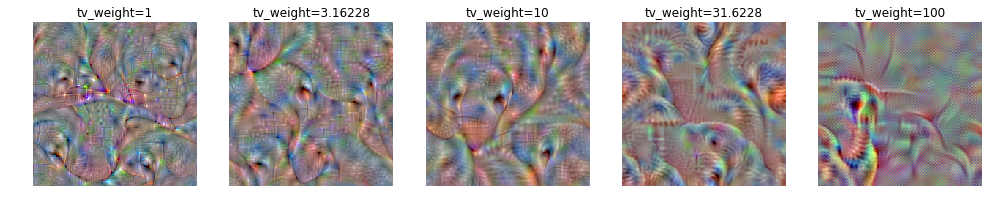

In [30]:
figsize(17,5)

fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True)

for i, tv_val in enumerate(np.logspace(0,2,5)):
    print(f"finding tv_weight=10**{np.log10(tv_val)}")

    img = visualize_activation(
        vgg, 
        layer_idx, 
        filter_indices=208,
        act_max_weight=2, 
        lp_norm_weight=20, 
        tv_weight=tv_val,
        input_modifiers=[Jitter()]
    )
    
    axes[i].imshow(img)
    axes[i].set_title(f"tv_weight={tv_val:g}")
    axes[i].axis("off")

finding Jitter=0.0
finding Jitter=0.0625
finding Jitter=0.125
finding Jitter=0.1875
finding Jitter=0.25


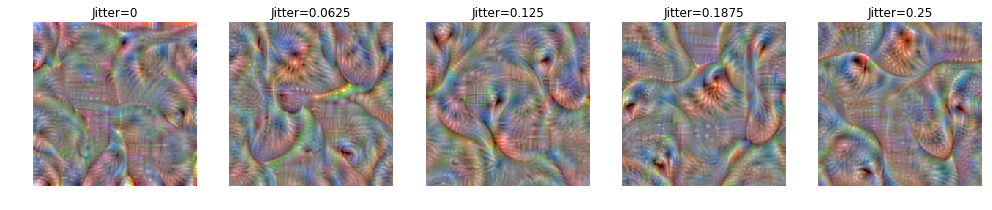

In [31]:
figsize(17,5)

fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True)

for i, j_val in enumerate(np.linspace(0,.25,5)):
    print(f"finding Jitter={j_val}")

    img = visualize_activation(
        vgg, 
        layer_idx, 
        filter_indices=208,
        act_max_weight=2, 
        lp_norm_weight=20, 
        tv_weight=12,
        input_modifiers=[Jitter(j_val)]
    )
    
    axes[i].imshow(img)
    axes[i].set_title(f"Jitter={j_val:g}")
    axes[i].axis("off")

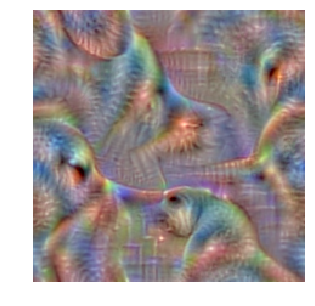

In [32]:
figsize(5,5)

img = visualize_activation(
    vgg, 
    layer_idx, 
    filter_indices=208,
    act_max_weight=2, 
    lp_norm_weight=20, 
    tv_weight=12,
    input_modifiers=[Jitter(.2)]
)
plt.imshow(img)
plt.axis("off");

In [33]:
import pickle, urllib

imagenet_label = pickle.load(
    urllib.request.urlopen(
        'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
    ))

finding 208
finding 209
finding 210
finding 211
finding 212
finding 213
finding 214
finding 215
finding 216
finding 217
finding 218
finding 219
finding 220
finding 221
finding 222
finding 223


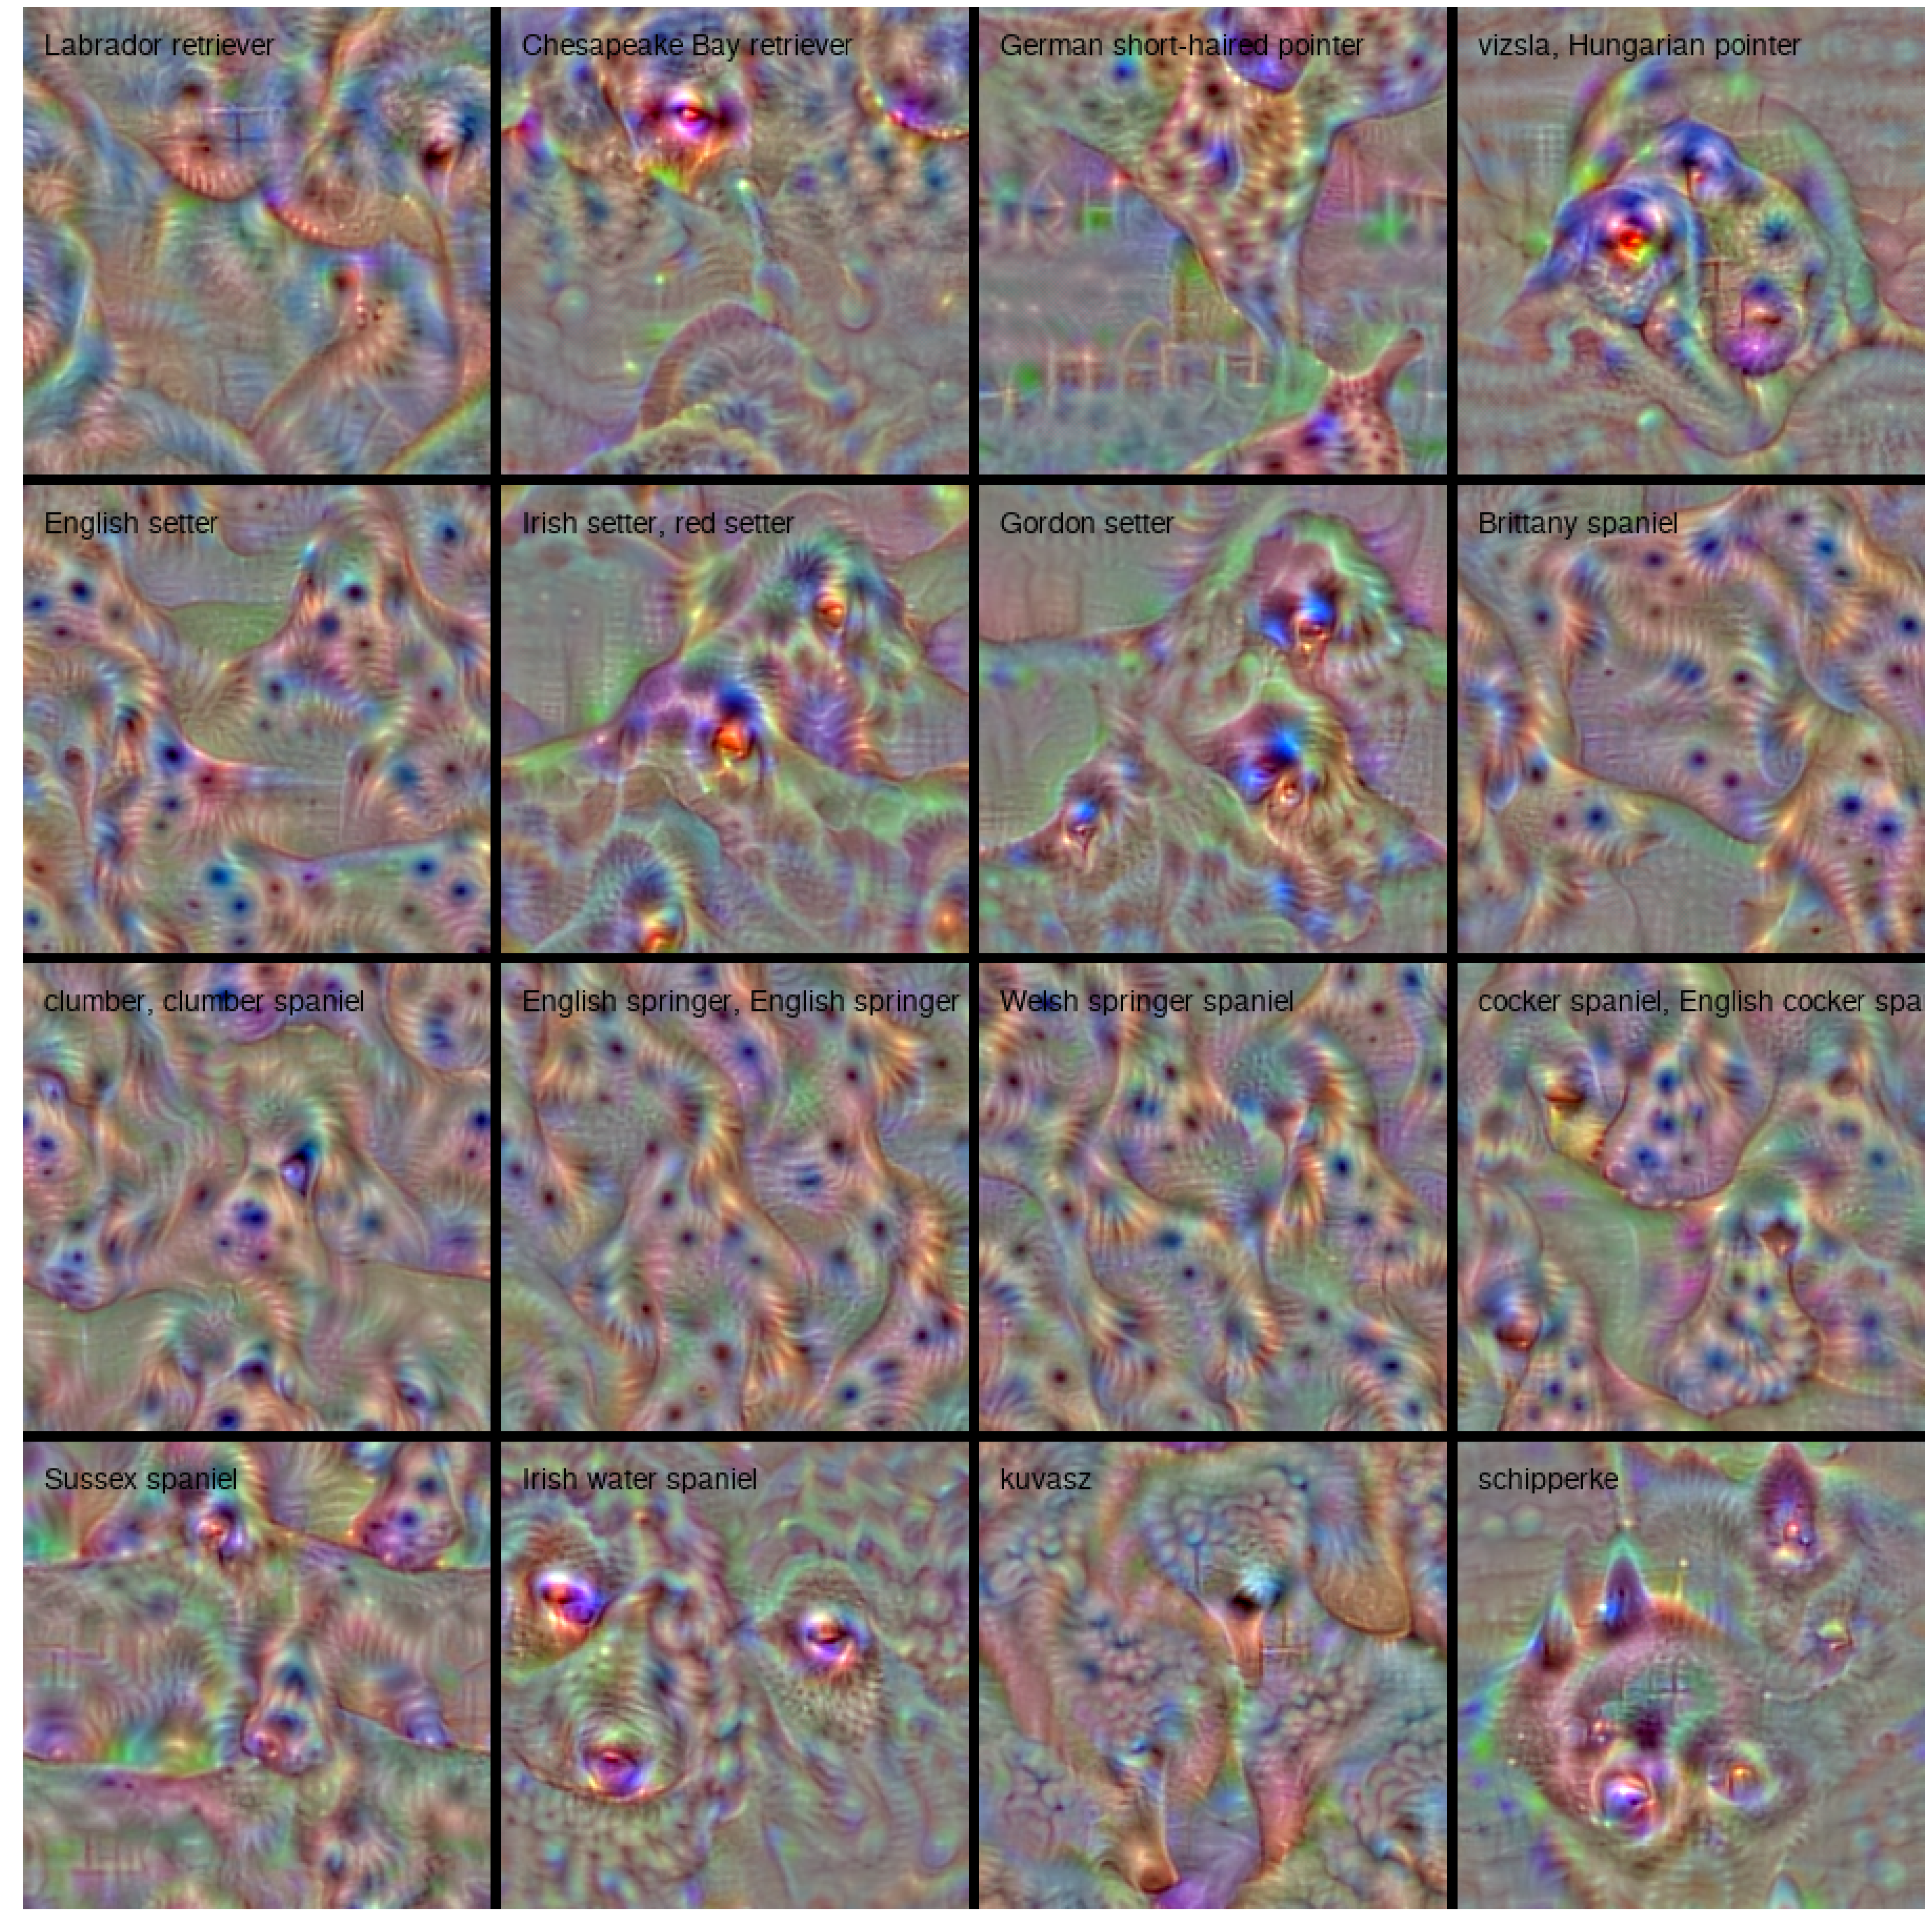

<Figure size 3600x3600 with 0 Axes>

In [35]:
categories = np.arange(208, 224)

vis_images = []
for idx in categories:
    print(f"finding {idx}")
    img = visualize_activation(vgg, layer_idx, filter_indices=idx, 
                                act_max_weight=2, 
                                lp_norm_weight=20, 
                                tv_weight=15,
                                input_modifiers=[Jitter(.25)]
                              )
    
    # Reverse lookup index to imagenet label and overlay it on the image.
    img = utils.draw_text(img, imagenet_label[idx])
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=4)
plt.axis('off')
plt.imshow(stitched)
plt.show()
plt.savefig("dogs.jpg")